### Comparing L1000 and Cell painting compound's values/scores based on their replicates

- Visualizing the median scores of cell painting cpds vs L1000 cpds using scatter plot.

- Visualizing the median scores distribution of both cell painting and L1000.

- Visualizing the signature strength of Cell painting vs L1000 compounds using scatter plot.

- Visualizing the MAS (Morphological activity score) of Cell painting vs TAS (Transcriptional activity score) L1000 compounds using scatter plot.

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
sns.set_style("darkgrid")
##sns.set_palette(["red", "green", "orange","blue","gray","purple"])
sns.set_context("talk")

In [2]:
cp_level4_path = '../cell_painting/cellpainting_lvl4_cpd_replicate_datasets'
L1000_level4_path = '../L1000/L1000_lvl4_cpd_replicate_datasets'

In [3]:
df_cp_med = pd.read_csv(os.path.join(cp_level4_path, 'cpd_replicate_median_scores.csv'))
df_L1_med = pd.read_csv(os.path.join(L1000_level4_path, 'cpd_replicate_median_scores.csv'))

In [4]:
df_cp_pvals = pd.read_csv(os.path.join(cp_level4_path, 'cpd_replicate_p_values.csv'))
df_L1_pvals = pd.read_csv(os.path.join(L1000_level4_path, 'cpd_replicate_p_values.csv'))

In [5]:
df_cp_all = pd.read_csv(os.path.join(cp_level4_path, 'cp_all_scores.csv'))
df_L1_all = pd.read_csv(os.path.join(L1000_level4_path, 'L1000_all_scores.csv'))

In [6]:
with open(os.path.join(cp_level4_path, 'CP_dmso_95_percentile_MAS.pickle'), 'rb') as handle:
    cp_dmso_95pct = pickle.load(handle)
with open(os.path.join(L1000_level4_path, 'L1000_dmso_95_percentile_TAS.pickle'), 'rb') as handle:
    L1_dmso_95pct = pickle.load(handle)

In [7]:
with open(os.path.join(cp_level4_path, 'null_dist_medians_per_dose.pickle'), 'rb') as handle:
    null_dist_med_cp = pickle.load(handle)
    
with open(os.path.join(L1000_level4_path, 'null_dist_medians_per_dose.pickle'), 'rb') as handle:
    null_dist_med_L1000 = pickle.load(handle)

In [8]:
def reproducible_dose(df, df_med):
    """
    This function computes how many reproducible median correlation scores 
    each compound has across all doses, (out of the 6 doses based on p-values)
    """
    df_new = df.set_index('cpd').rename_axis(None, axis=0).drop(['cpd_size'], axis = 1).copy()
    cpd_values = {cpd:sum(df_new.loc[cpd] <= 0.05) for cpd in df_new.index}
    df['No_of_reproducible_doses'] = cpd_values.values()
    df_med['No_of_reproducible_doses'] = cpd_values.values()
    
    return df, df_med

In [9]:
df_cp_pvals, df_cp_med = reproducible_dose(df_cp_pvals, df_cp_med)
df_L1_pvals, df_L1_med = reproducible_dose(df_L1_pvals, df_L1_med)

In [10]:
def rename_cols(df):
    'Rename columns from dose number to actual doses'
    
    df.rename(columns= {'dose_1' : '0.04 uM', 'dose_2':'0.12 uM', 'dose_3':'0.37 uM',
                        'dose_4': '1.11 uM', 'dose_5':'3.33 uM', 'dose_6':'10 uM'}, inplace = True)
    return df

In [11]:
df_cp_med = rename_cols(df_cp_med)
df_L1_med = rename_cols(df_L1_med)

In [12]:
df_cp_pvals = rename_cols(df_cp_pvals)
df_L1_pvals = rename_cols(df_L1_pvals)

In [13]:
def melt_df(df, col_name):
    """Reconstruct the dataframe into 4 columns: cpd, cpd_size, No_of_reproducible_doses, doses"""
    df_melt = df.melt(id_vars=['cpd', 'cpd_size', 'No_of_reproducible_doses'], var_name="dose", value_name=col_name)
    return df_melt

In [14]:
def melt_L1000_CP(df_cp,df_L1):
    """
    Reconstruct Cell painting and L1000 dataframes, 
    by tranforming the dose columns into vertical rows
    """
    cp_cpd = df_cp.cpd.values.tolist()
    L1_cpd = df_L1.cpd.values.tolist()
    all_cpds = [x for x in cp_cpd if x in L1_cpd]
    df_cp_med =df_cp.loc[df_cp['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_L1_med = df_L1.loc[df_L1['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_cp_melt = melt_df(df_cp_med, 'Cell painting')
    df_L1_melt = melt_df(df_L1_med,'L1000')
    
    return df_cp_melt, df_L1_melt

In [15]:
df_cp_melt, df_L1_melt = melt_L1000_CP(df_cp_med,df_L1_med)

In [16]:
df_L1_melt.head()

cpd  cpd_size  No_of_reproducible_doses  \
0  17-hydroxyprogesterone-caproate         3                         3   
1                    2-iminobiotin         2                         1   
2                3-amino-benzamide         3                         1   
3                 3-deazaadenosine         2                         0   
4                          ABT-737         3                         1   

      dose     L1000  
0  0.04 uM  0.024738  
1  0.04 uM -0.133693  
2  0.04 uM  0.051959  
3  0.04 uM  0.065967  
4  0.04 uM  0.016400

In [17]:
def merge_L1000_CP(df_cp, df_L1):
    
    """Merge L1000 and Cell painting dataframes based on compounds and doses found in both dataframes"""
    
    df_cp_new = df_cp.rename(columns={"Cell painting": "median scores"})
    df_cp_new['profile_tech'] = 'Cell painting'
    df_L1_new = df_L1.rename(columns={"L1000": "median scores"})
    df_L1_new['profile_tech'] = 'L1000'
    df_cp_L1 = pd.concat([df_cp_new, df_L1_new], ignore_index=True)
    
    df_cp_nw = df_cp.rename(columns={"cpd_size": "cpd_size_CP", 
                          "No_of_reproducible_doses": "No_of_reproducible_doses-Cell painting"})
    df_L1_nw = df_L1.rename(columns={"cpd_size": "cpd_size_L1000",
                          "No_of_reproducible_doses": "No_of_reproducible_doses-L1000"})
    df_L1_cp_merge = df_cp_nw.merge(df_L1_nw, on=['cpd', 'dose'])
    return df_cp_L1, df_L1_cp_merge

In [18]:
df_cp_L1_melt, df_L1_cp_med = merge_L1000_CP(df_cp_melt, df_L1_melt)

In [19]:
df_cp_L1_melt.head()

cpd  cpd_size  No_of_reproducible_doses  \
0  17-hydroxyprogesterone-caproate         5                         6   
1                    2-iminobiotin         5                         0   
2                3-amino-benzamide         5                         6   
3                 3-deazaadenosine         5                         1   
4                          ABT-737         5                         6   

      dose  median scores   profile_tech  
0  0.04 uM       0.511133  Cell painting  
1  0.04 uM       0.123800  Cell painting  
2  0.04 uM       0.421004  Cell painting  
3  0.04 uM       0.077982  Cell painting  
4  0.04 uM       0.265878  Cell painting

In [20]:
cp_95pct = [np.percentile(null_dist_med_cp[keys],95) for keys in null_dist_med_cp]

In [21]:
L1000_95pct = [np.percentile(null_dist_med_L1000[keys],95) for keys in null_dist_med_L1000]

### - Plot median scores of L1000 vs Cell painting compound replicates

In [22]:
def plot_median_scores(df, L1000_95pct, cp_95pct, title, path, file_name, hue = 'Cell painting', 
                       alp =0.4, size =(50,300)):
    
    """Plot median scores of L1000 versus Cell painting"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    rel_plt = sns.relplot(data=df, x="Cell painting", y="L1000", col="dose", 
                          hue = 'No_of_reproducible_doses-'+ hue, size = 'No_of_reproducible_doses-'+ hue, sizes= size,
                          kind="scatter", palette=sns.color_palette("crest", as_cmap=True), 
                          col_wrap=3, height=5.5, aspect=1.3, alpha = alp)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    for idx, val in enumerate(zip(L1000_95pct, cp_95pct)):
        rel_plt.axes[idx].axhline(y = val[0], ls='--', color = 'black', alpha = 0.7, label = '95th null distribution')
        rel_plt.axes[idx].axvline(x = val[1], ls='--', color = 'black', alpha = 0.7)
    rel_leg = rel_plt._legend
    rel_leg.set_bbox_to_anchor([0.90, 0.51])
    plt.legend(bbox_to_anchor=(1.01, 0.505), loc='lower left')
    rel_plt.legend.set_title('Number of\nreproducible\ndoses\n' + '('+ hue +')')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

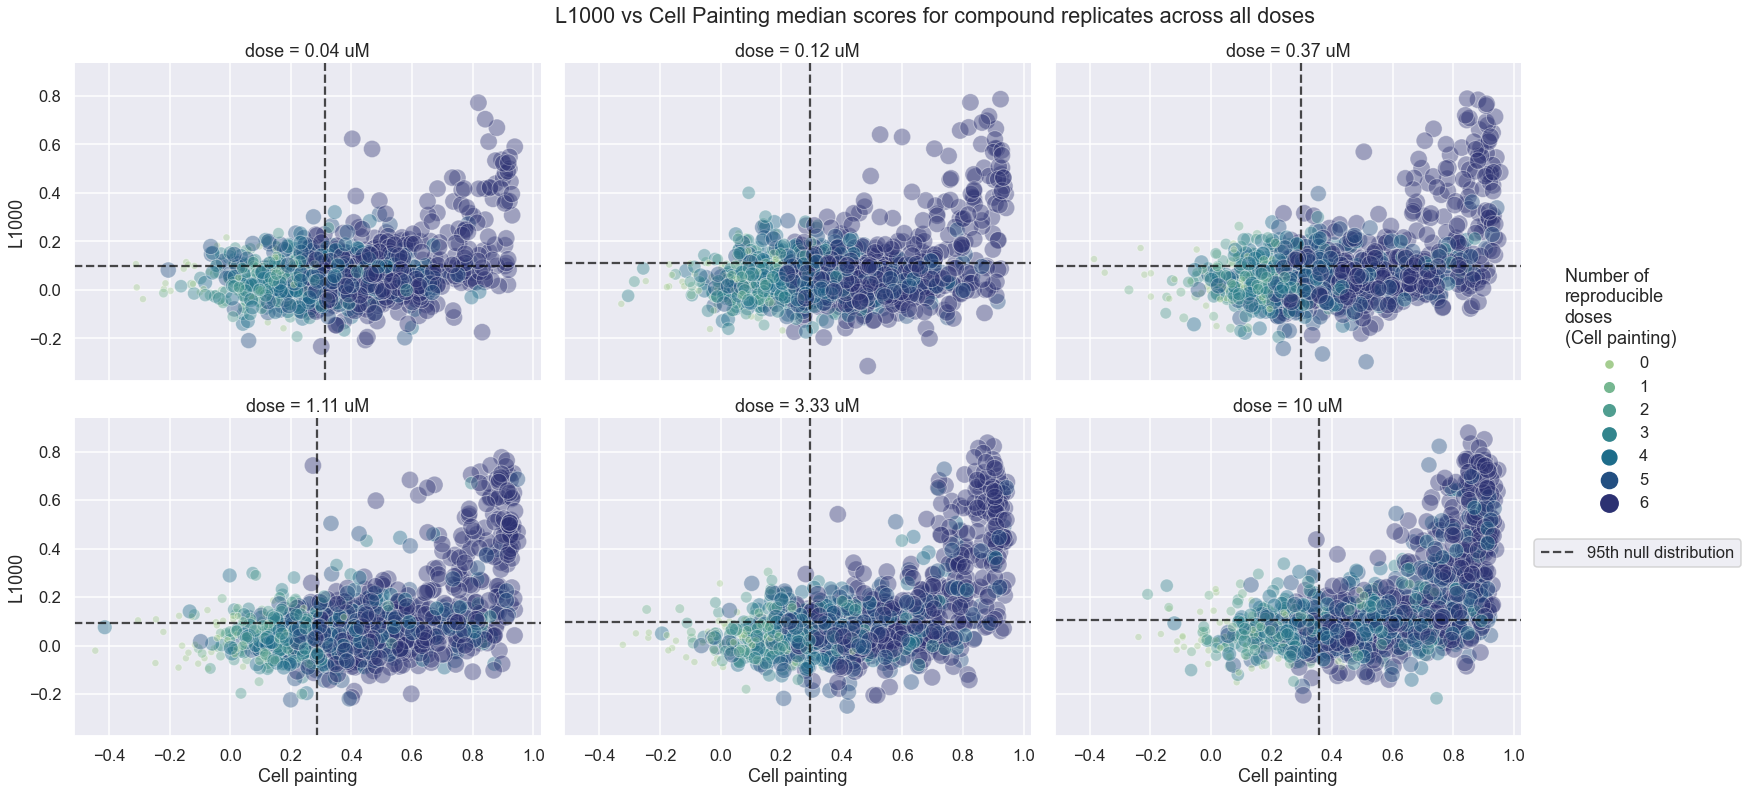

In [23]:
plot_median_scores(df_L1_cp_med, L1000_95pct, cp_95pct, 
                   "L1000 vs Cell Painting median scores for compound replicates across all doses",
                   'L1000_cp_figures', 'median_scores_plot_1a.png')

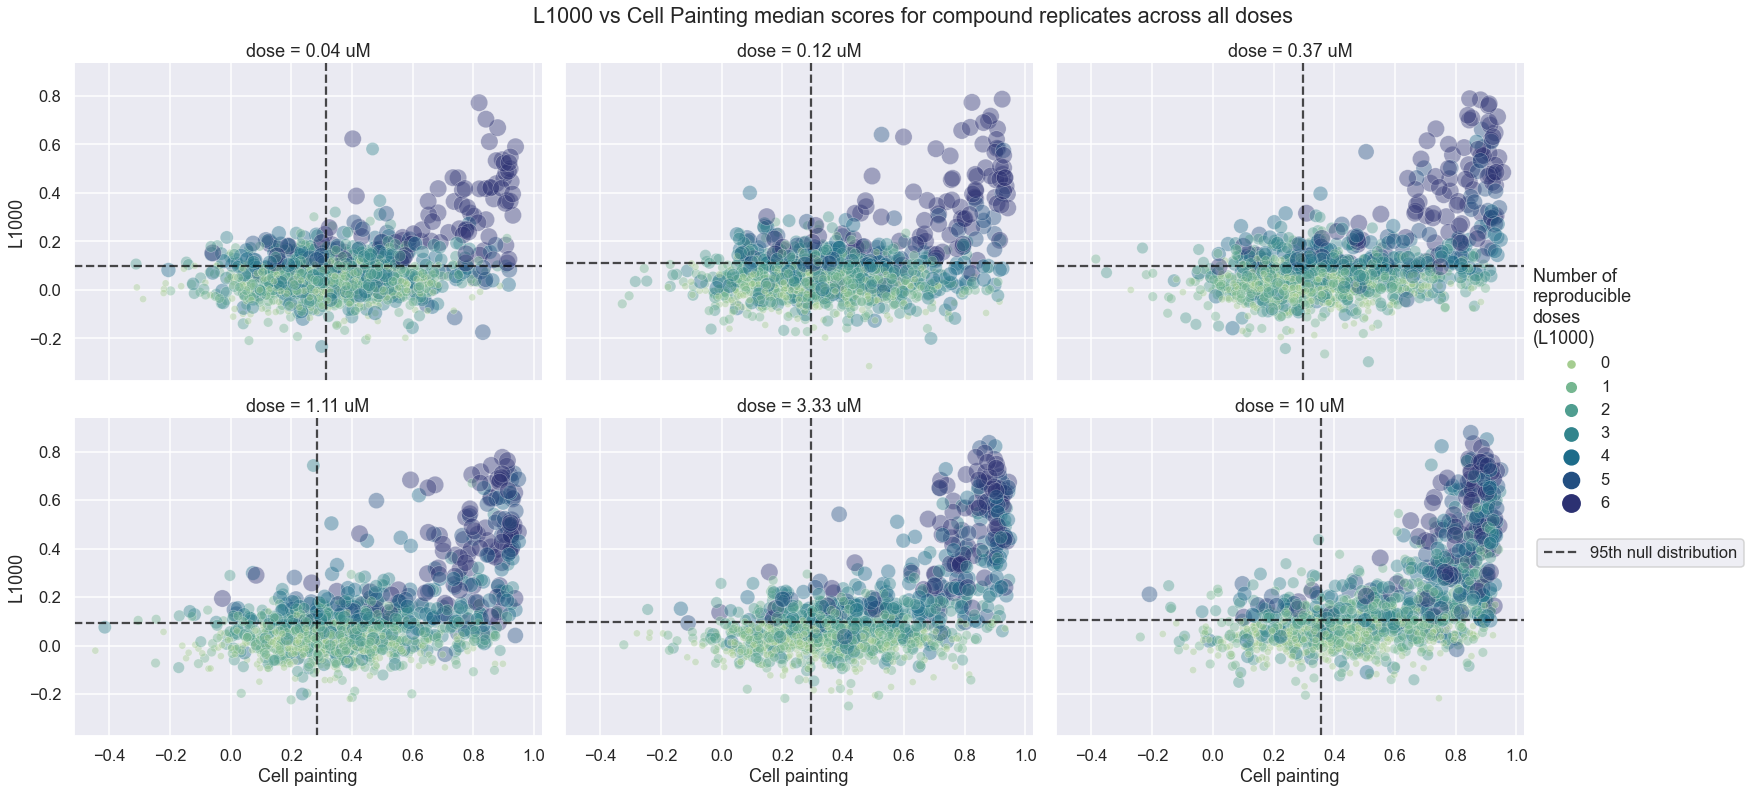

In [24]:
plot_median_scores(df_L1_cp_med, L1000_95pct, cp_95pct, 
                   "L1000 vs Cell Painting median scores for compound replicates across all doses",
                   'L1000_cp_figures', 'median_scores_plot_1b.png', hue = 'L1000')

In [25]:
def plot_median_distribution(df, title, path, file_name, plot_type = "hist"):
    """
    This function plot the frequency distribution of the median scores 
    of compounds measured in cell painting and L1000
    """
    if not os.path.exists(path):
        os.mkdir(path)
    dist_plt = sns.displot(df, x = 'median scores', col = 'dose', col_wrap=3, hue='profile_tech',
                          palette = sns.set_palette(["gray","purple"]), height=5.5, aspect=1.1, kind=plot_type)
    dist_plt.legend.set_title("")
    dist_plt.fig.suptitle(title)
    dist_plt.fig.subplots_adjust(top=.90)
    plt.savefig(os.path.join(path, file_name))
    plt.show()

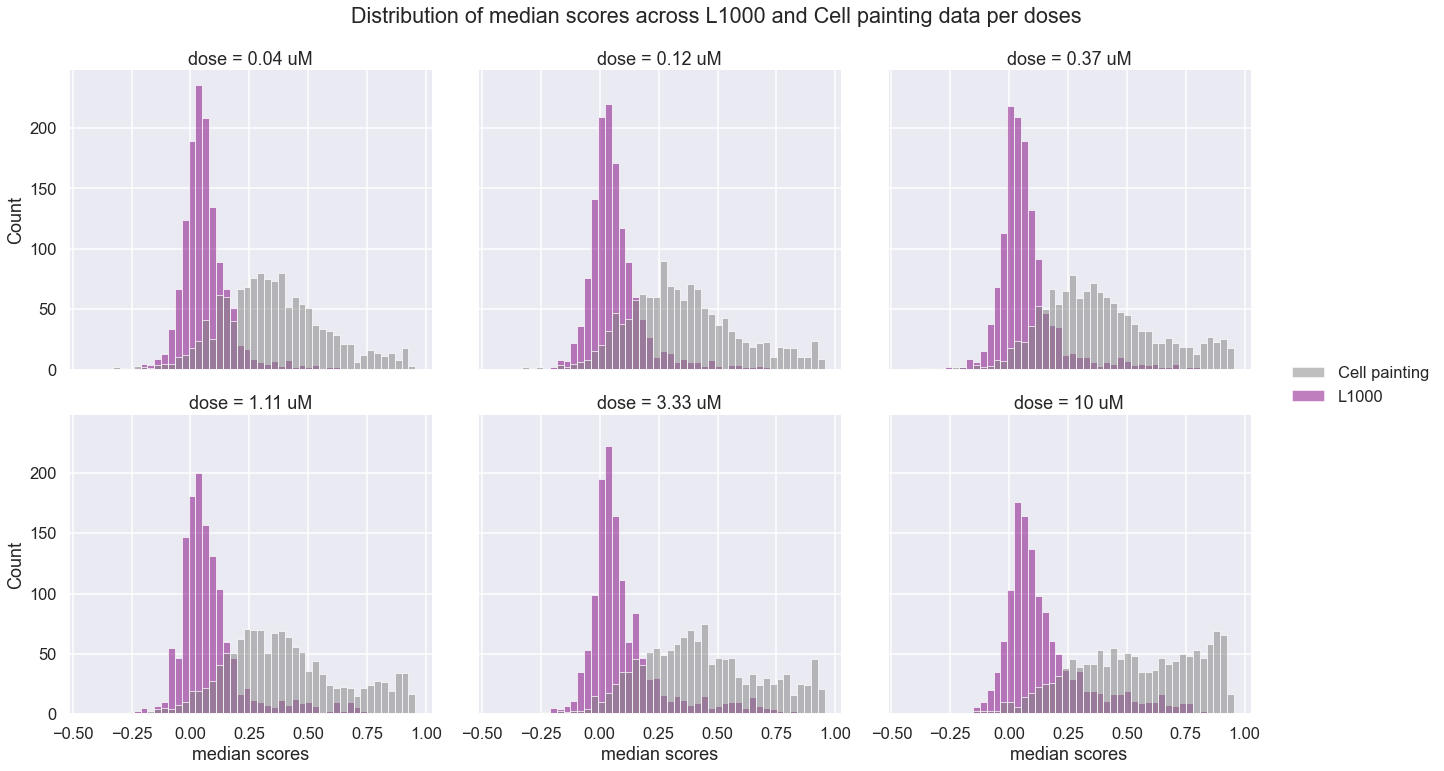

In [26]:
plot_median_distribution(df_cp_L1_melt, 'Distribution of median scores across L1000 and Cell painting data per doses', 
                         'L1000_cp_figures', 'median_score_distribution.png', plot_type = "hist")

In [27]:
def plot_median_dist(df, path, file_name):
    
    """
    This function plot the frequency distribution of the median scores 
    of compounds measured in cell painting and L1000
    """
    if not os.path.exists(path):
        os.mkdir(path)
        
    dist = sns.displot(df, x="median scores", col="profile_tech", col_wrap=2, hue = 'dose', 
                       palette = sns.set_palette(["red", "green", "orange","blue","gray","purple"]), 
                       height=6.5, aspect=1.5, multiple="stack")
    dist.fig.suptitle('Distribution of median scores across L1000 and Cell painting data per doses')
    dist.fig.subplots_adjust(top=.85)
    axes = dist.axes.flatten()
    axes[0].set_title("Cell Painting")
    axes[1].set_title("L1000")
    plt.savefig(os.path.join(path, file_name))
    plt.show()

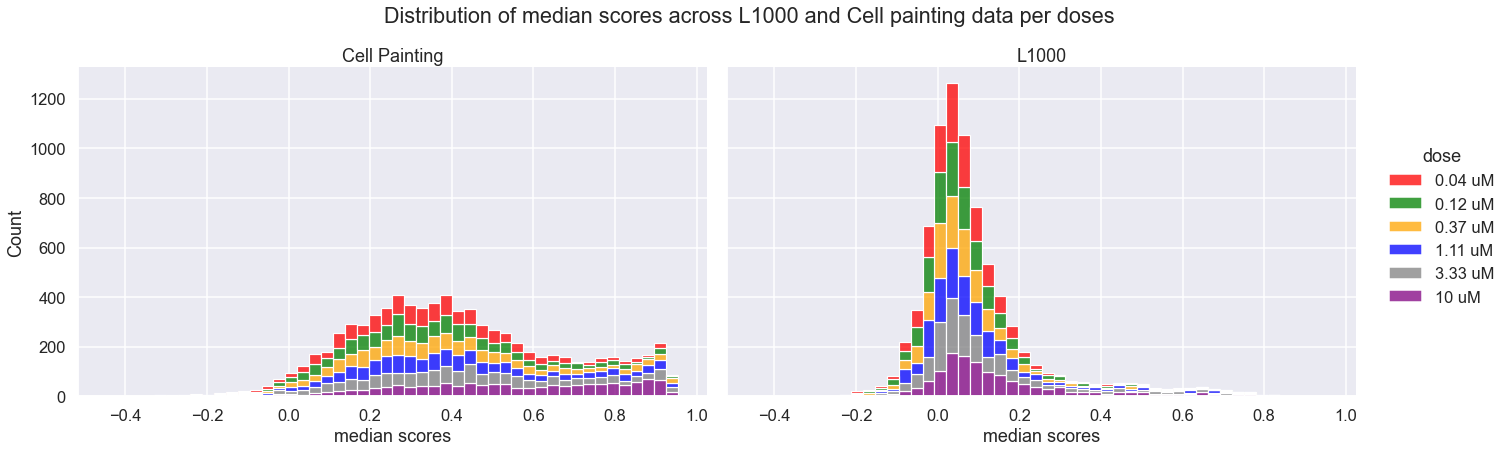

In [28]:
plot_median_dist(df_cp_L1_melt, 'L1000_cp_figures', 'median_score_dist.png')

### - Compounds with reproducible median correlation values (i.e. p_values below 0.05) in 1.11 - 10uM doses

In [29]:
def stat_significant_df(df_cp_pvalues, df_L1_pvalues, df_cp_medscores, df_L1_medscores):
    """
    This function compounds with reproducible median scores 
    across the last 3 doses (1.11-10uM) found in both cell painting and L1000
    """
    stat_cp_cpds = df_cp_pvalues[df_cp_pvalues['No_of_reproducible_doses'] >= 4]['cpd'].values.tolist()
    stat_L1_cpds = df_L1_pvalues[df_L1_pvalues['No_of_reproducible_doses'] >= 4]['cpd'].values.tolist()
    stat_cpds = [x for x in stat_cp_cpds if x in stat_L1_cpds]
    df_stat_cp = df_cp_medscores.loc[df_cp_medscores['cpd'].isin(stat_cpds)].reset_index(drop=True)
    df_stat_L1 = df_L1_medscores.loc[df_L1_medscores['cpd'].isin(stat_cpds)].reset_index(drop=True)
    
    return df_stat_cp, df_stat_L1

In [30]:
df_stat_cp, df_stat_L1 = stat_significant_df(df_cp_pvals, df_L1_pvals, df_cp_melt, df_L1_melt)

In [31]:
df_cp_L1_stat_melt, df_L1_cp_stat_med = merge_L1000_CP(df_stat_cp, df_stat_L1)

In [32]:
df_L1_cp_stat_med.head()

cpd  cpd_size_CP  No_of_reproducible_doses-Cell painting     dose  \
0    AT-7519            5                                       6  0.04 uM   
1   AZD-5438            5                                       6  0.04 uM   
2   AZD-8330            5                                       6  0.04 uM   
3    BI-2536            5                                       6  0.04 uM   
4  BIBX-1382            5                                       4  0.04 uM   

   Cell painting  cpd_size_L1000  No_of_reproducible_doses-L1000     L1000  
0       0.634882               3                               4  0.123918  
1       0.423969               3                               6  0.258015  
2       0.841461               3                               6  0.289763  
3       0.910175               3                               6  0.368031  
4       0.237930               3                               4  0.059230

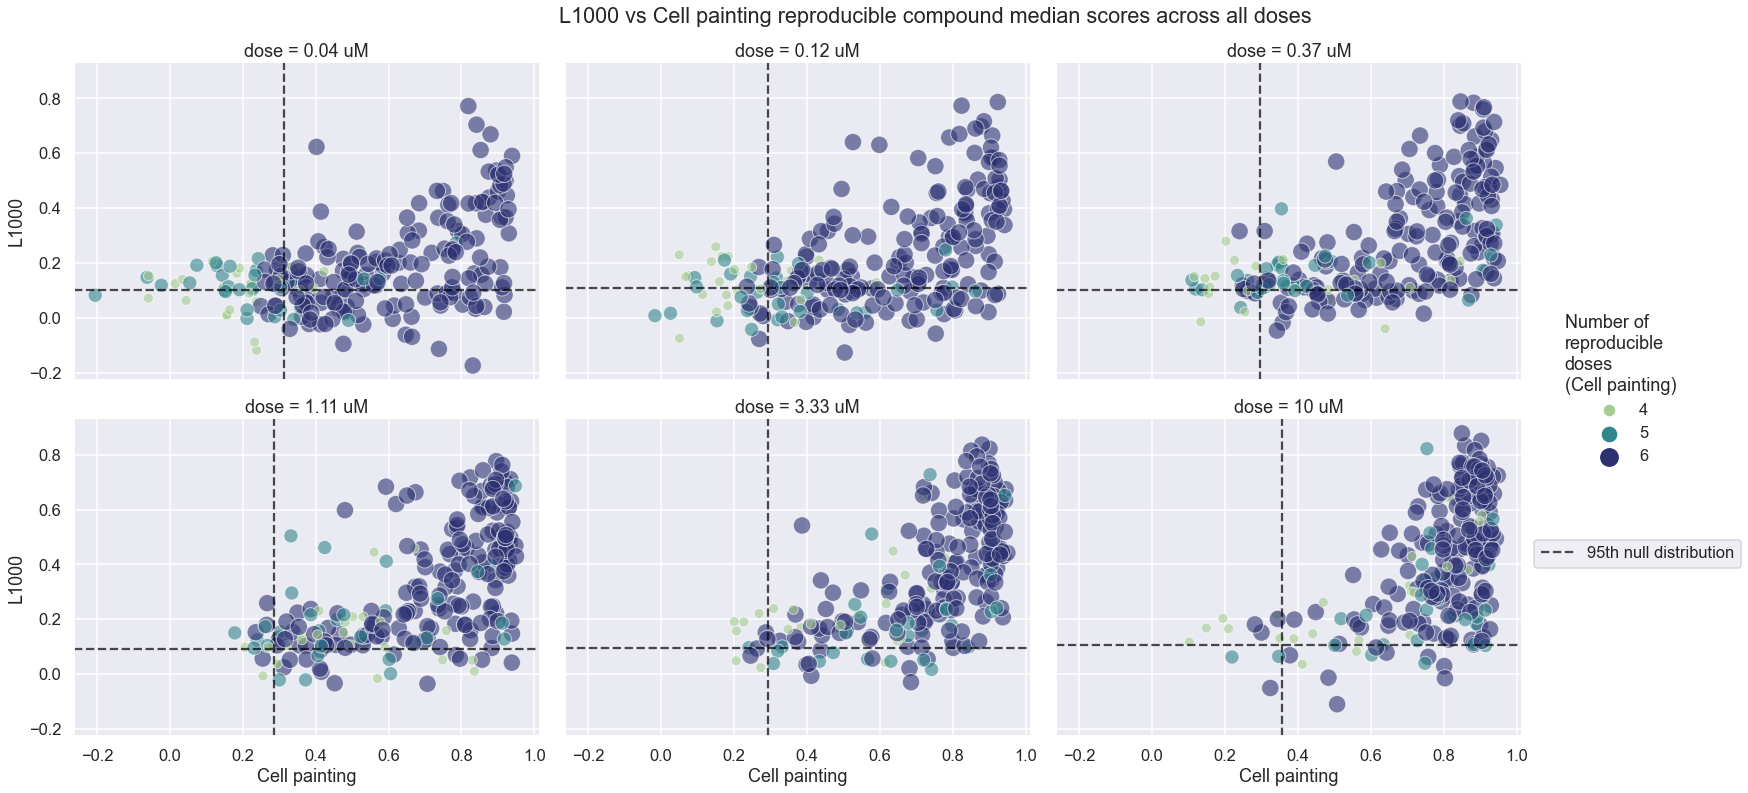

In [33]:
plot_median_scores(df_L1_cp_stat_med, L1000_95pct, cp_95pct, 
                   "L1000 vs Cell painting reproducible compound median scores across all doses",
                   'L1000_cp_figures', 'stat_sign_med_scores_plot1a.png',  alp =0.6, size =(100,300))

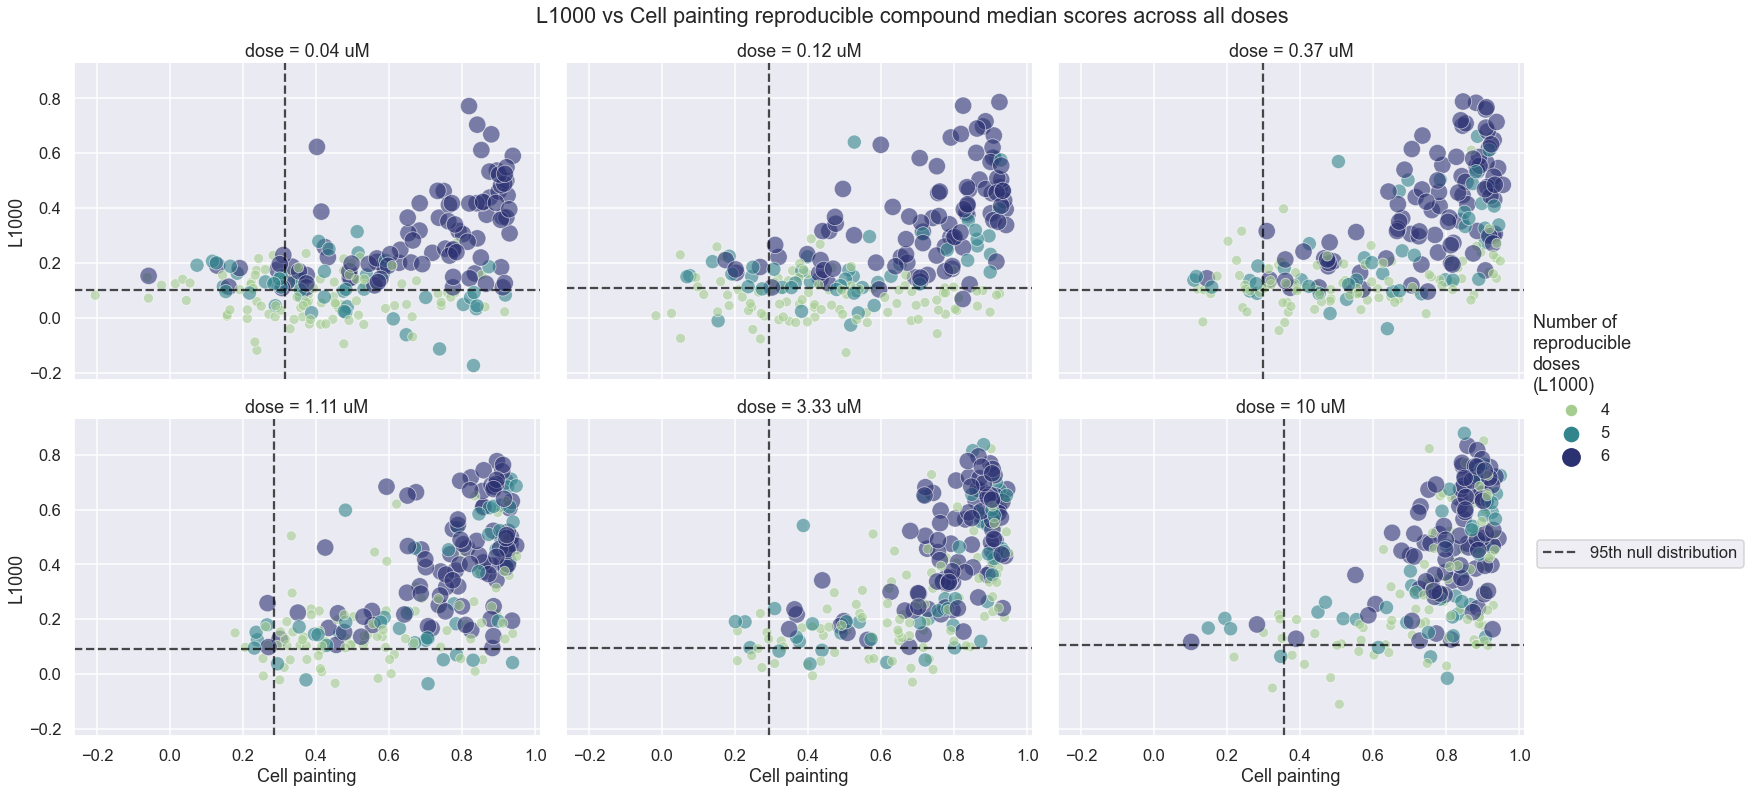

In [34]:
plot_median_scores(df_L1_cp_stat_med, L1000_95pct, cp_95pct, 
                   "L1000 vs Cell painting reproducible compound median scores across all doses",
                   'L1000_cp_figures', 'stat_sign_med_scores_plot1b.png',
                   hue = 'L1000', alp =0.6, size =(100,300))

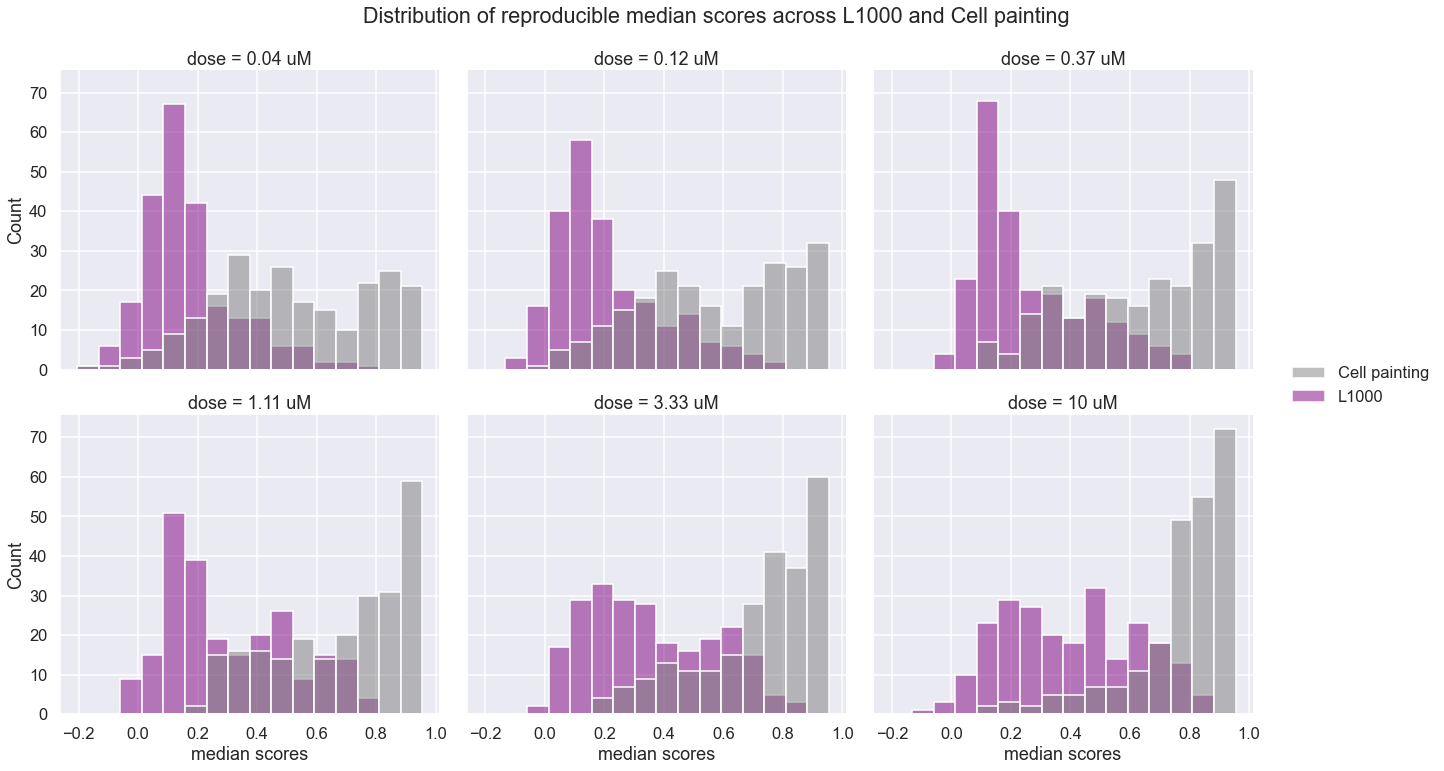

In [35]:
plot_median_distribution(df_cp_L1_stat_melt, 'Distribution of reproducible median scores across L1000 and Cell painting', 
                         'L1000_cp_figures', 'stat_med_score_dist.png', plot_type = "hist")

### - Number of compounds with reproducible median scores for Cell painting and L1000 across all doses

In [36]:
def reproducible_no_of_cpd(df_L1, df_cp):
    """
    This function returns a dataframe that includes number of compounds 
    with reproducible median scores in each of the 6 doses for both cell painting and L1000
    """
    columns = ['0.04 uM','0.12 uM','0.37 uM','1.11 uM','3.33 uM','10 uM']
    no_of_L1_cpd = {col:df_L1.loc[(df_L1[col] <= 0.05)].shape[0] for col in columns}
    no_of_cp_cpd = {col:df_cp.loc[(df_cp[col] <= 0.05)].shape[0] for col in columns}
    df_cpd = pd.DataFrame.from_dict(no_of_L1_cpd, orient='index', columns = ['L1000'])
    df_cpd['Cell painting'] = no_of_cp_cpd.values()
    
    return df_cpd

In [37]:
df_cpd = reproducible_no_of_cpd(df_L1_pvals, df_cp_pvals)

In [38]:
def plot_no_of_cpd_dose(df, path, file_name):
    
    """Plot number of compounds with reproducible median scores for Cell painting and L1000 per dose"""
    if not os.path.exists(path):
        os.mkdir(path)   
    fig, axes = plt.subplots(2, 3, sharey=True)
    fig.suptitle('Number of compounds with reproducible median scores')
    fig.subplots_adjust(top=.91)
    axes = axes.flatten()
    fig.set_size_inches(22.7, 12.27)
    columns = ['0.04 uM','0.12 uM','0.37 uM','1.11 uM','3.33 uM','10 uM']
    for idx, col in enumerate(columns):
        sns.barplot(ax=axes[idx], x=df.loc[col].index, y=df.loc[col].values, palette=['#eb3434', '#eb7a34'])
        axes[idx].set_title(df.loc[col].name)
    [axes[i].set_ylabel("Number of compounds") for i in range(0, 1)]
    [axes[i].set_ylabel("Number of compounds") for i in range(3, 4)] 
    plt.savefig(os.path.join(path, file_name))
    plt.show()

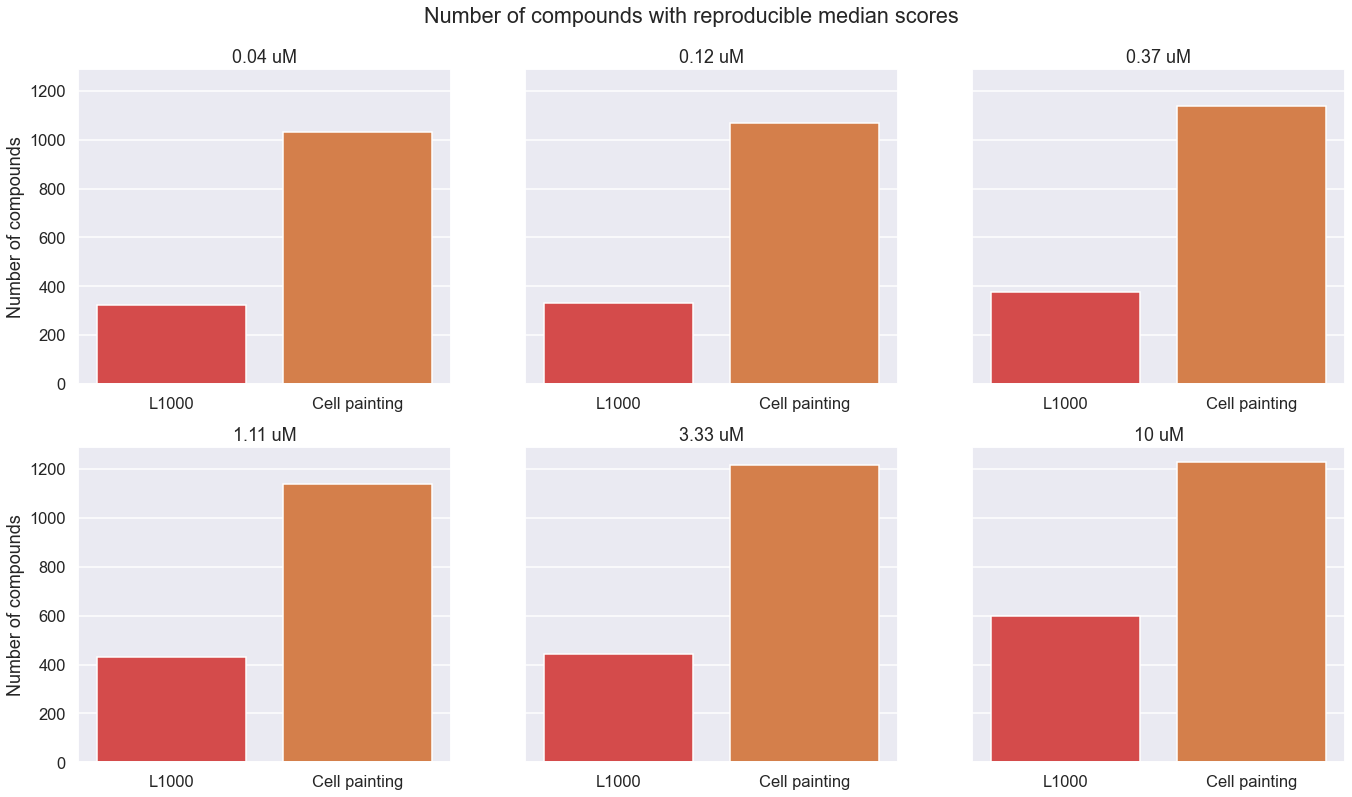

In [39]:
plot_no_of_cpd_dose(df_cpd, 'L1000_cp_figures', 'no_of_reprod_cpd_per_dose.png')

In [40]:
def plot_no_of_cpd(df, path, file_name):
    
    """Plot number of compounds with reproducible median scores for Cell painting and L1000"""
    if not os.path.exists(path):
        os.mkdir(path)
    fig, axes = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Number of compounds with reproducible median scores')
    fig.subplots_adjust(top=.80)
    axes = axes.flatten()
    fig.set_size_inches(18.7, 5.27)
    for idx, col in enumerate(['L1000', 'Cell painting']):
        sns.barplot(ax=axes[idx], x=df[col].index, y=df[col].values, palette=['#eb3434', '#eb7a34', '#ebae34', 
                                                                              '#a45445', '#ea7862', '#eabe62'])
        axes[idx].set_title(df_cpd[col].name)
    [axes[i].set_ylabel("Number of compounds") for i in range(0, 1)]
    plt.savefig(os.path.join(path, file_name))
    plt.show()

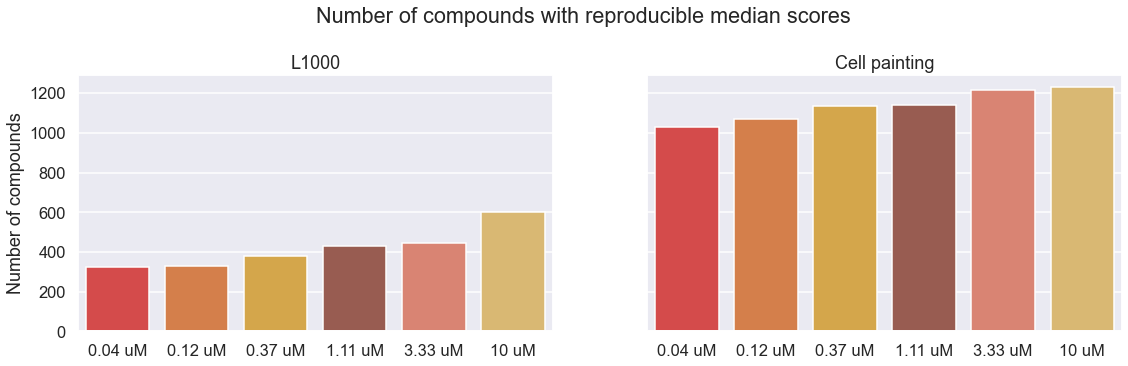

In [41]:
plot_no_of_cpd(df_cpd, 'L1000_cp_figures', 'no_of_reproducible_cpd.png')

### Visualizing TAS, MAS and signature strength scores for L1000 vs Cell painting

In [42]:
def merge_L1000_CP_2(df_cp,df_L1):
    
    """Merge Cell painting and L1000 dataframes based on compounds and doses found in both dataframes"""
    
    cp_cpd = df_cp['cpd'].unique().tolist()
    L1_cpd = df_L1['cpd'].unique().tolist()
    all_cpds = [x for x in cp_cpd if x in L1_cpd]
    
    df_cp_scores =df_cp.loc[df_cp['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_L1_scores = df_L1.loc[df_L1['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_cp_scores.rename({'replicate_correlation':'median_scores_CP', 
                         'signature_strength':'Cell_painting_SS'}, axis = 1, inplace=True)
    df_L1_scores.rename({'replicate_correlation':'median_scores_L1000', 
                         'signature_strength':'L1000_SS'}, axis = 1, inplace=True)
    df_L1_cp = df_cp_scores.merge(df_L1_scores, on=['cpd', 'dose'])
    return df_L1_cp

In [43]:
df_L1_cp_all = merge_L1000_CP_2(df_cp_all,df_L1_all)

In [44]:
df_L1_cp_all[['No_of_reproducible_doses-Cell painting', 'No_of_reproducible_doses-L1000']] = \
df_L1_cp_med[['No_of_reproducible_doses-Cell painting', 'No_of_reproducible_doses-L1000']]

In [45]:
def plot_mas_vs_tas(df, title, L1_dmso_95pct, cp_dmso_95pct, path, file_name, hue = 'Cell painting', 
                    alp = 0.3, size =(50,300)):
    
    """Plot L1000 Transcriptional activity score (TAS) vs Cell Painting Morphological activity score (MAS)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    rel_plt = sns.relplot(data=df, x="MAS", y="TAS", col="dose", hue = 'No_of_reproducible_doses-' + hue,
                          size = 'No_of_reproducible_doses-' + hue, sizes= size, kind="scatter", 
                          palette=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),
                          col_wrap=3, height=5.5, aspect=1.3, alpha = alp)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    for idx in range(6):
        rel_plt.axes[idx].axhline(y = L1_dmso_95pct, ls='--', color = 'black', alpha = 0.8, label = '95th-DMSO TAS score')
        rel_plt.axes[idx].axvline(x = cp_dmso_95pct, ls='--', color = 'red', alpha = 0.8, label = '95th-DMSO MAS score')
    rel_leg = rel_plt._legend
    rel_leg.set_bbox_to_anchor([0.90, 0.51])
    plt.legend(bbox_to_anchor=(1.01, 0.495), loc='lower left')
    rel_plt.legend.set_title('Number of\nreproducible\ndoses\n' + '('+ hue +')')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

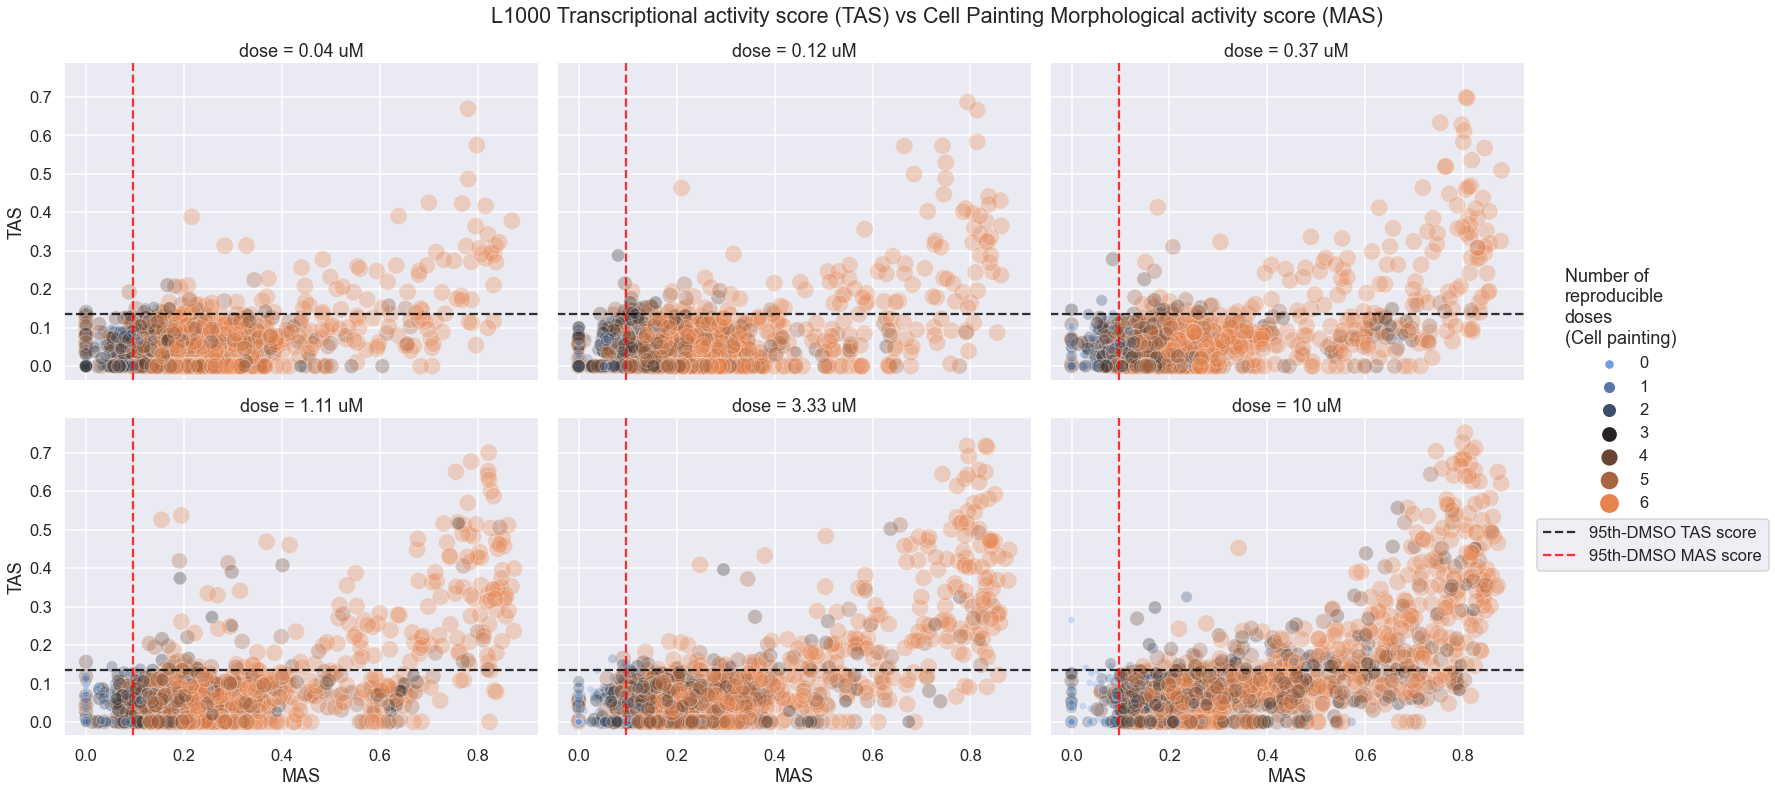

In [46]:
plot_mas_vs_tas(df_L1_cp_all, "L1000 Transcriptional activity score (TAS) vs Cell Painting Morphological activity score (MAS)",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'TAS_vs_MAS_1a.png')

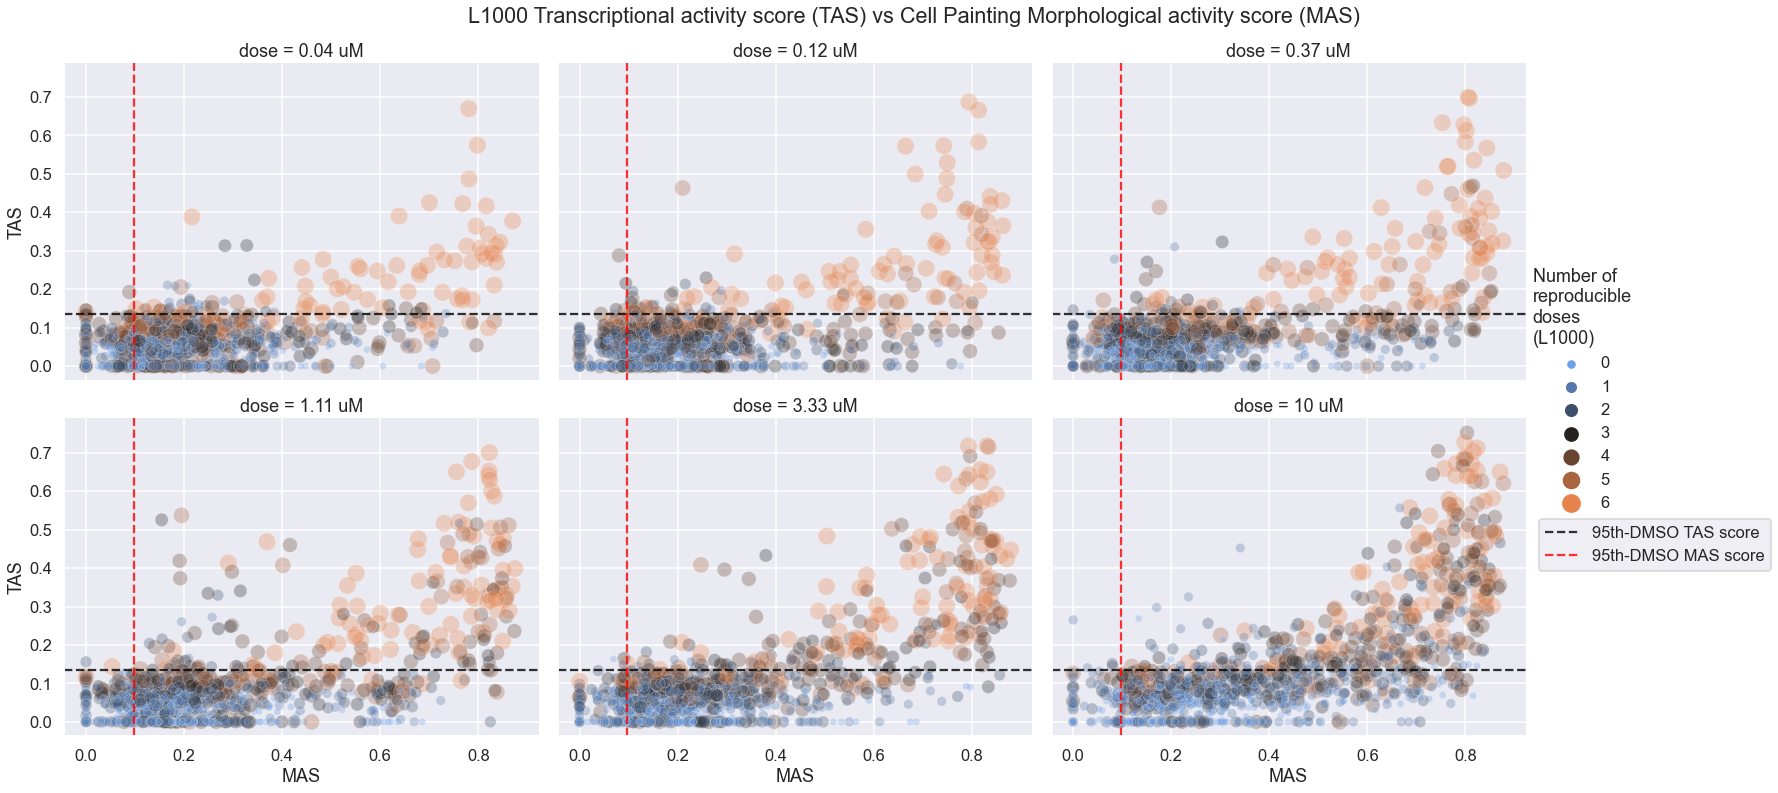

In [47]:
plot_mas_vs_tas(df_L1_cp_all, "L1000 Transcriptional activity score (TAS) vs Cell Painting Morphological activity score (MAS)",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'TAS_vs_MAS_1b.png', hue = 'L1000')

In [48]:
def plot_ss(df, title, path, file_name, hue = 'Cell painting', alp=0.3, size =(50,300)):
    
    """Plot L1000 vs Cell Painting signature strength"""
    if not os.path.exists(path):
        os.mkdir(path)
    rel_plt = sns.relplot(data=df, x='Cell_painting_SS', y='L1000_SS', col="dose", 
                          hue = 'No_of_reproducible_doses-' + hue, size = 'No_of_reproducible_doses-' + hue, 
                          sizes= size, kind="scatter", 
                          palette=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),
                          col_wrap=3, height=5.5, aspect=1.3, alpha = alp)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    rel_leg = rel_plt._legend
    rel_leg.set_bbox_to_anchor([0.90, 0.51])
    rel_plt.legend.set_title('Number of\nreproducible\ndoses\n' + '('+ hue +')')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

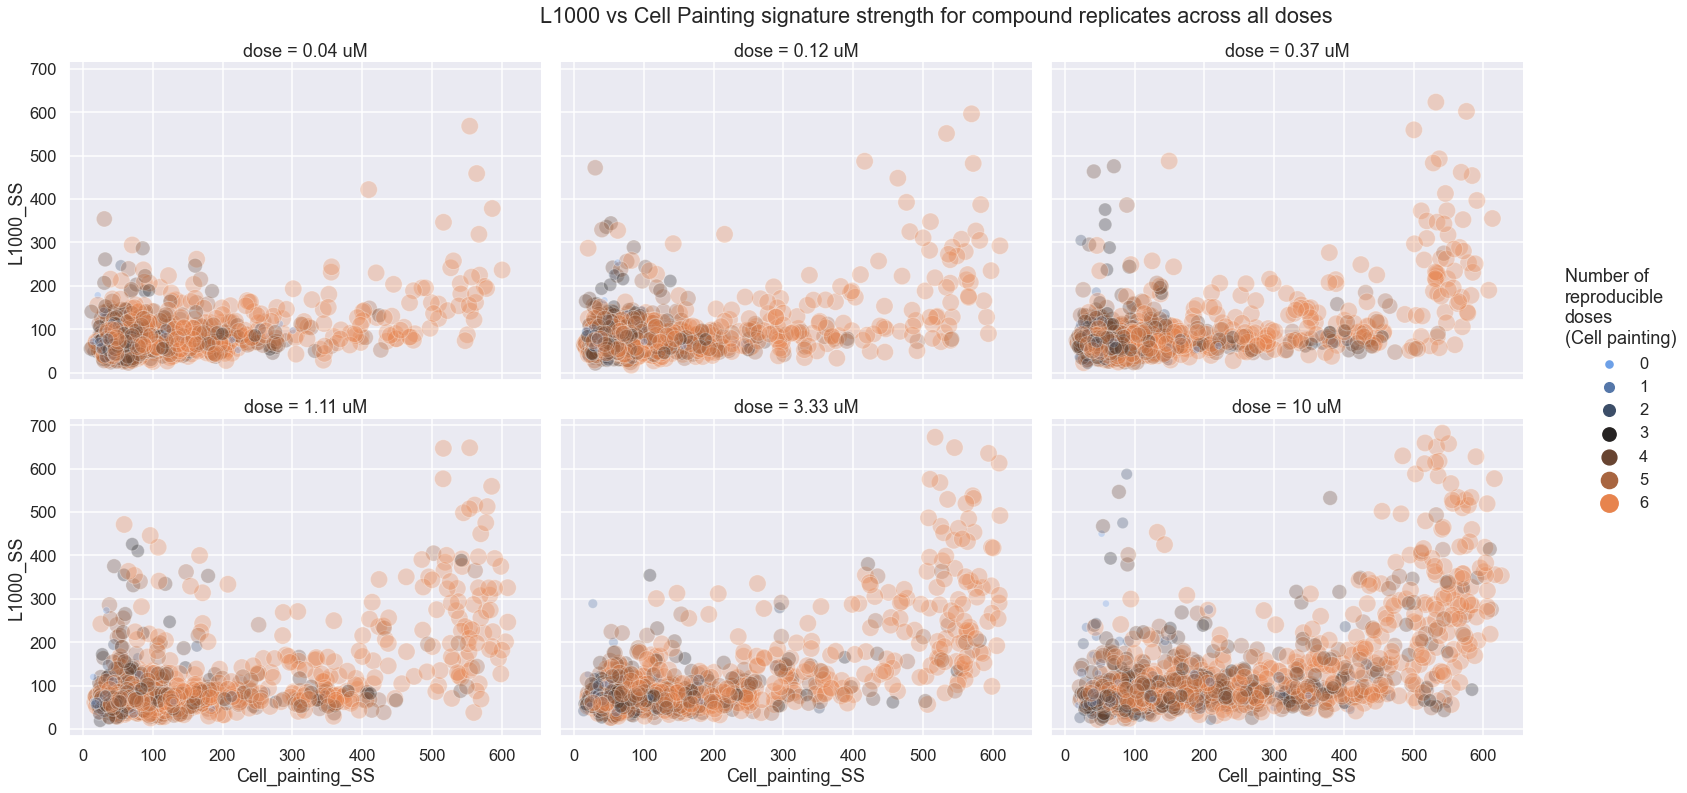

In [49]:
plot_ss(df_L1_cp_all, "L1000 vs Cell Painting signature strength for compound replicates across all doses",
                'L1000_cp_figures', 'L1000_SS_vs_CP_SS_1a.png')

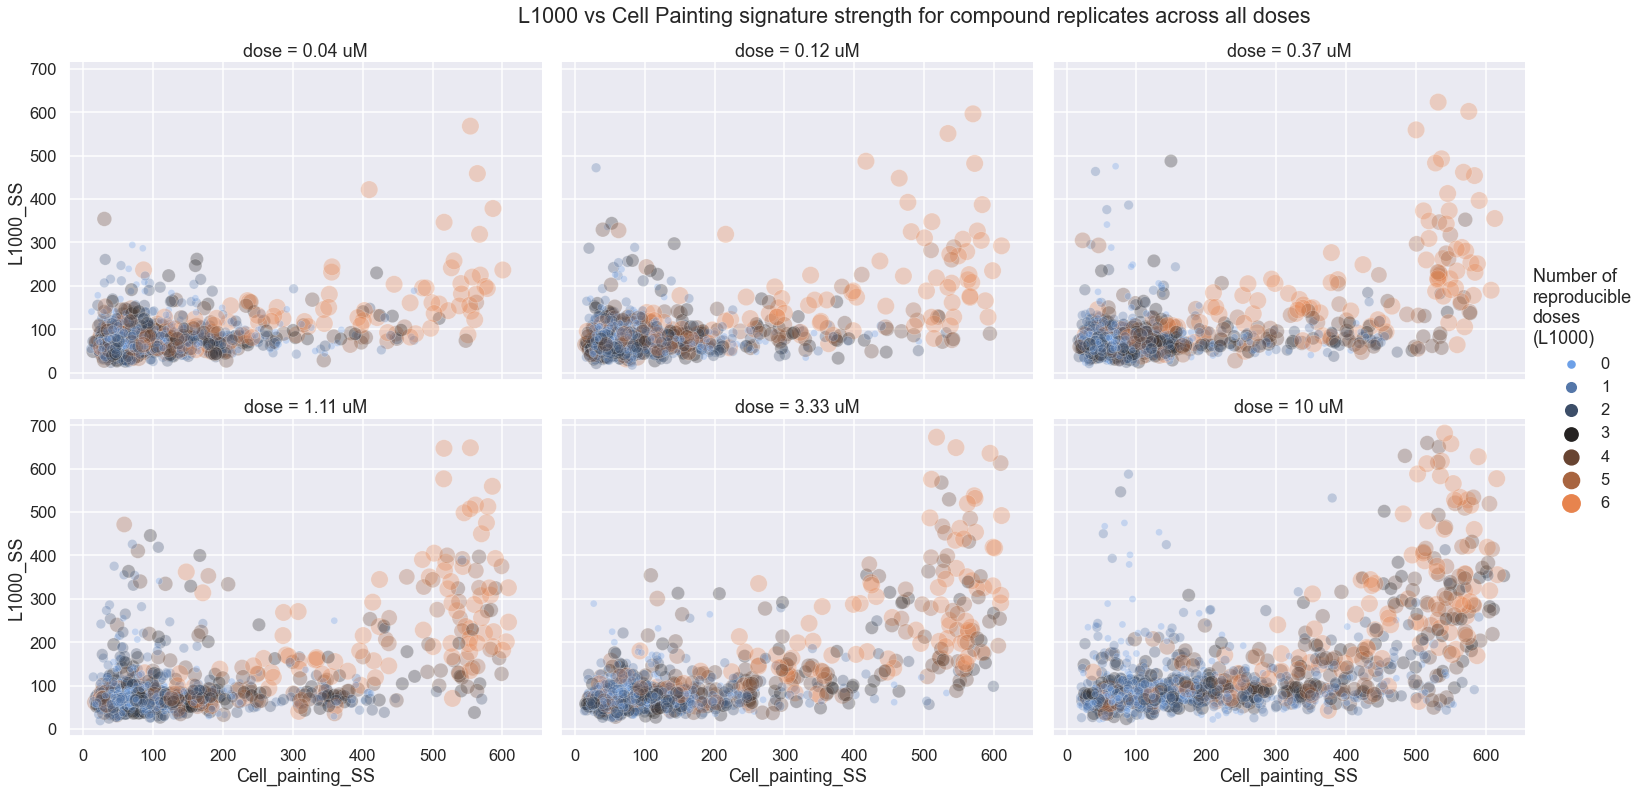

In [50]:
plot_ss(df_L1_cp_all, "L1000 vs Cell Painting signature strength for compound replicates across all doses",
                'L1000_cp_figures', 'L1000_SS_vs_CP_SS_1b.png', hue = 'L1000')

### - Compounds with high MAS but low TAS (i.e. TAS below 0.3 and MAS > 0.7)

In [51]:
df_highmas_lowtas = df_L1_cp_all[(df_L1_cp_all['TAS'] < 0.3) & (df_L1_cp_all['MAS'] > 0.7)].copy()

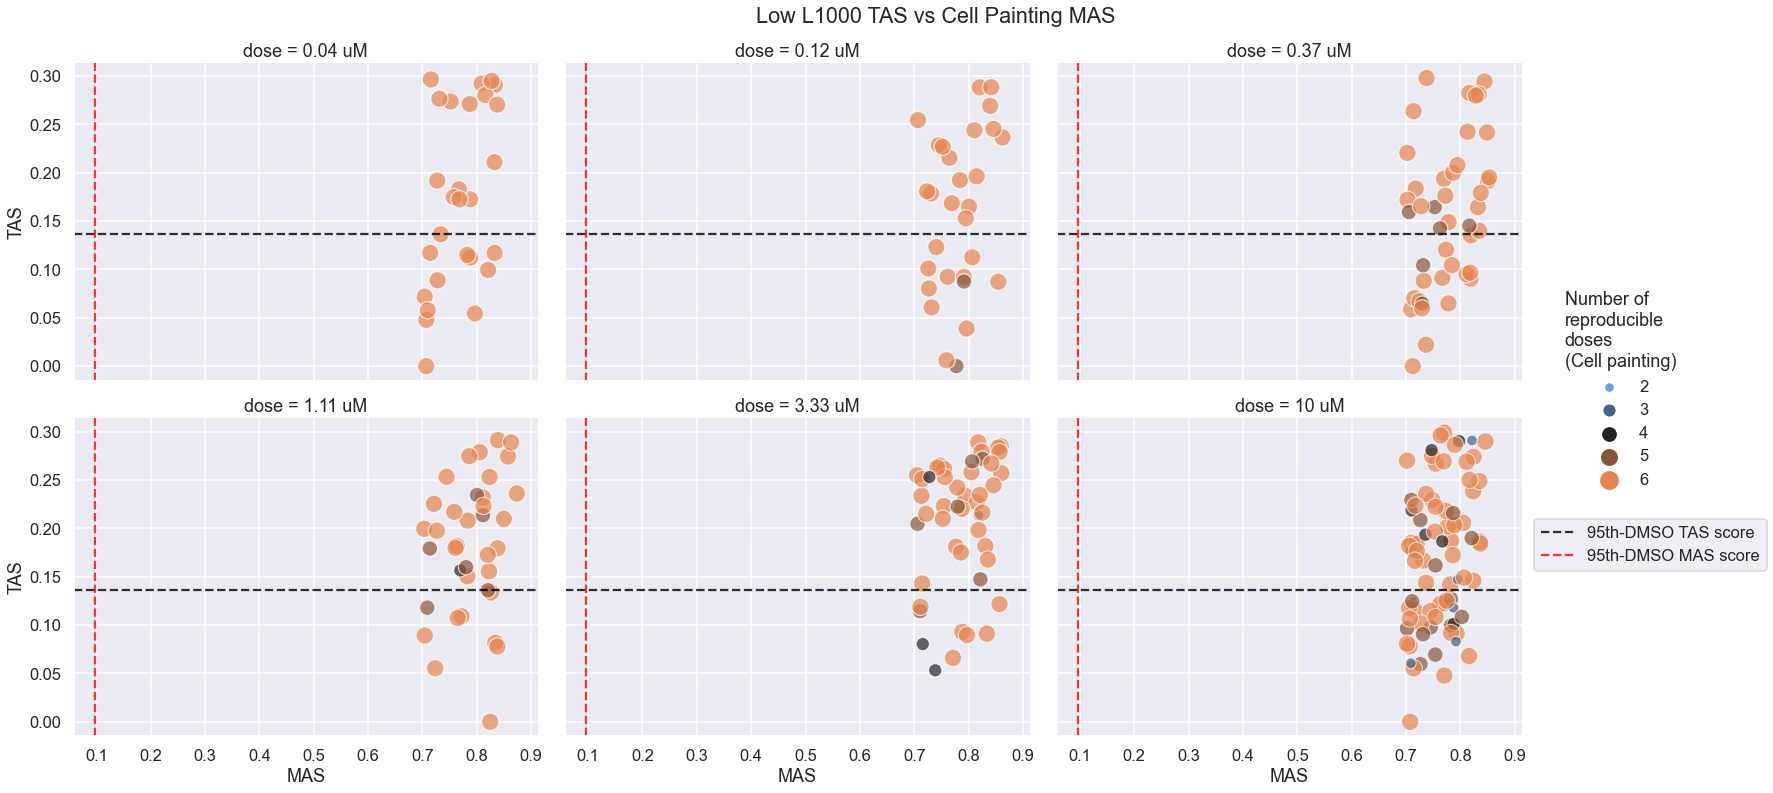

In [52]:
plot_mas_vs_tas(df_highmas_lowtas, "Low L1000 TAS vs Cell Painting MAS",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'Low_TAS_vs_High_MAS_1a.png', alp = 0.7)

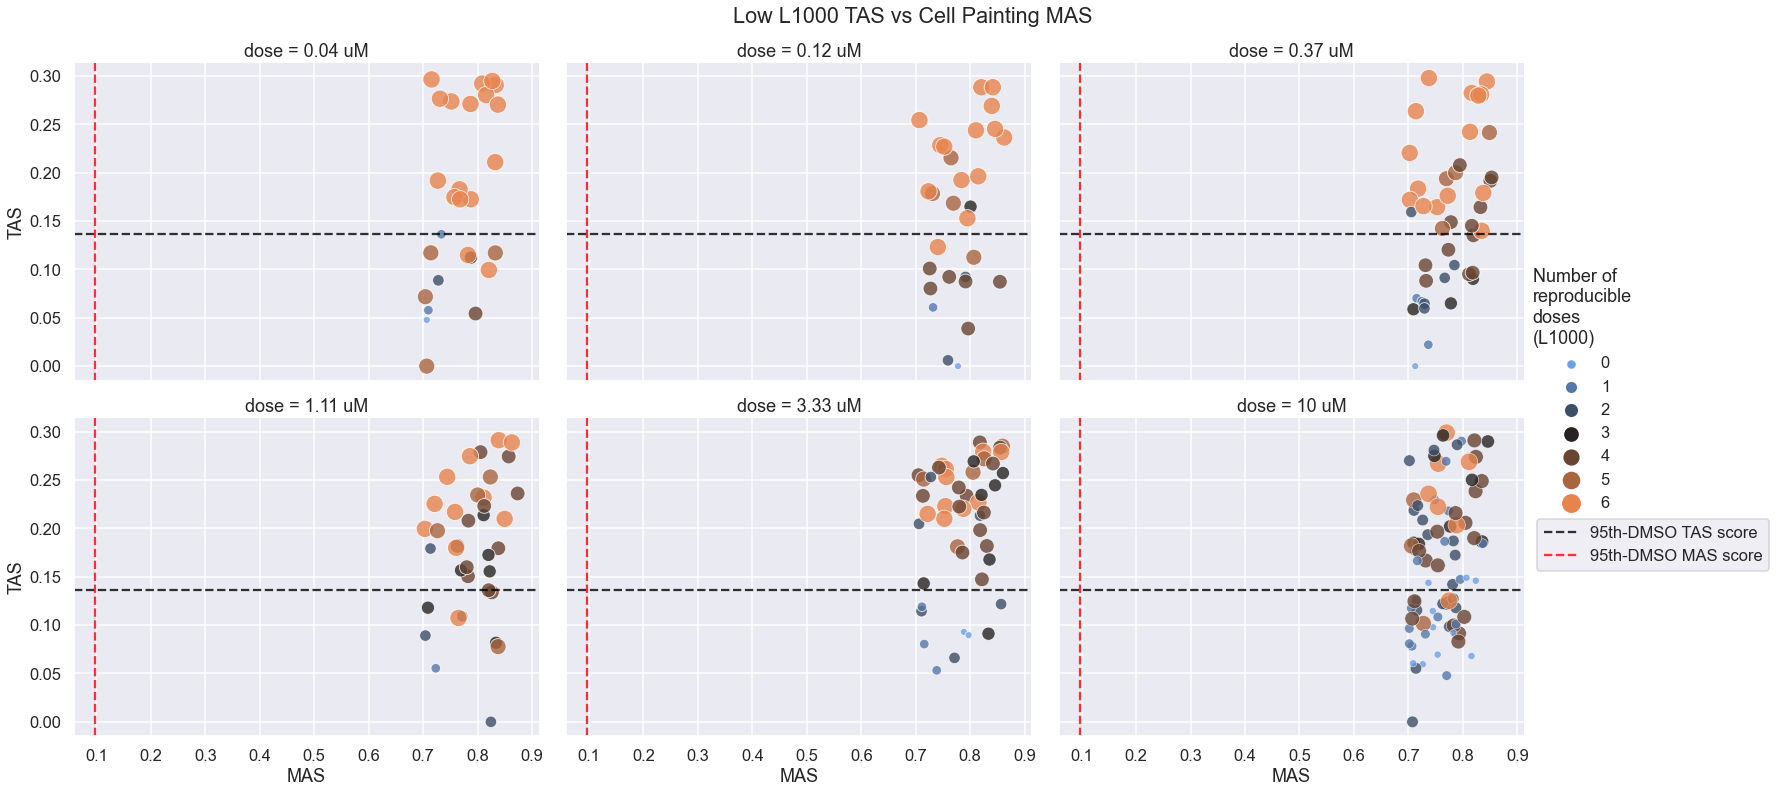

In [53]:
plot_mas_vs_tas(df_highmas_lowtas, "Low L1000 TAS vs Cell Painting MAS",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'Low_TAS_vs_High_MAS_1b.png', 
                hue = 'L1000',alp = 0.8)

### - Compounds (i.e. p-values below 0.05) with reproducible median correlation values in 1.11 - 10uM doses

### - Plot the MAS vs TAS;

### -  L1000 vs Cell painting Signature Strength

In [54]:
stat_cpds = df_stat_cp['cpd'].unique().tolist()

In [55]:
len(stat_cpds)

236

In [56]:
df_stat_all = df_L1_cp_all.loc[df_L1_cp_all['cpd'].isin(stat_cpds)].reset_index(drop=True)

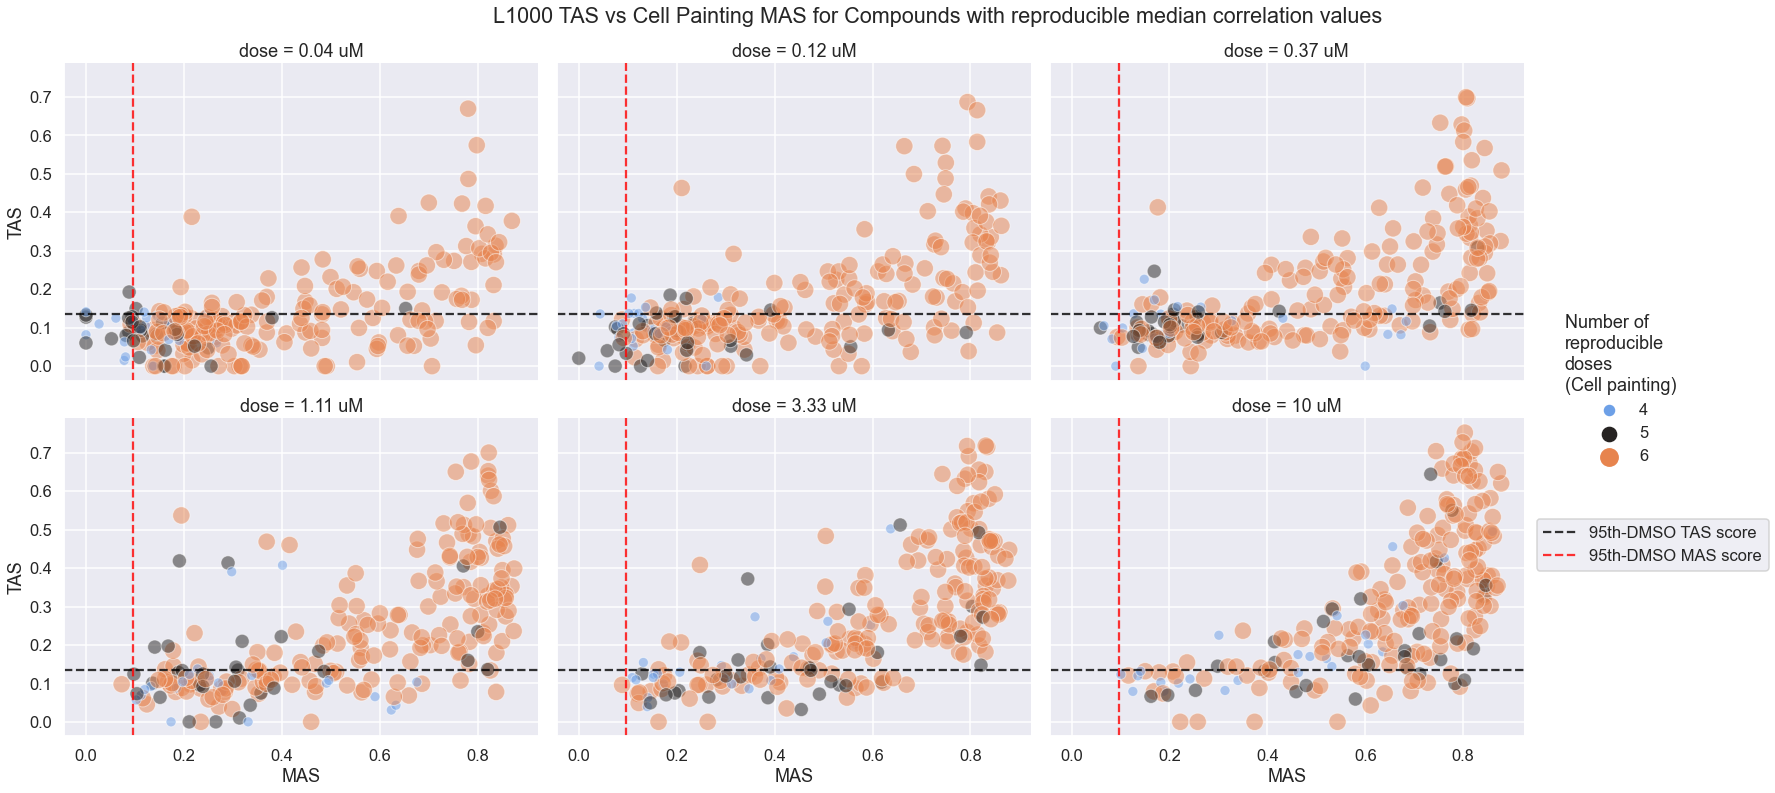

In [57]:
plot_mas_vs_tas(df_stat_all, "L1000 TAS vs Cell Painting MAS for Compounds with reproducible median correlation values",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'stat_TAS_vs_MAS_1a.png', alp=0.5, size =(100,300))

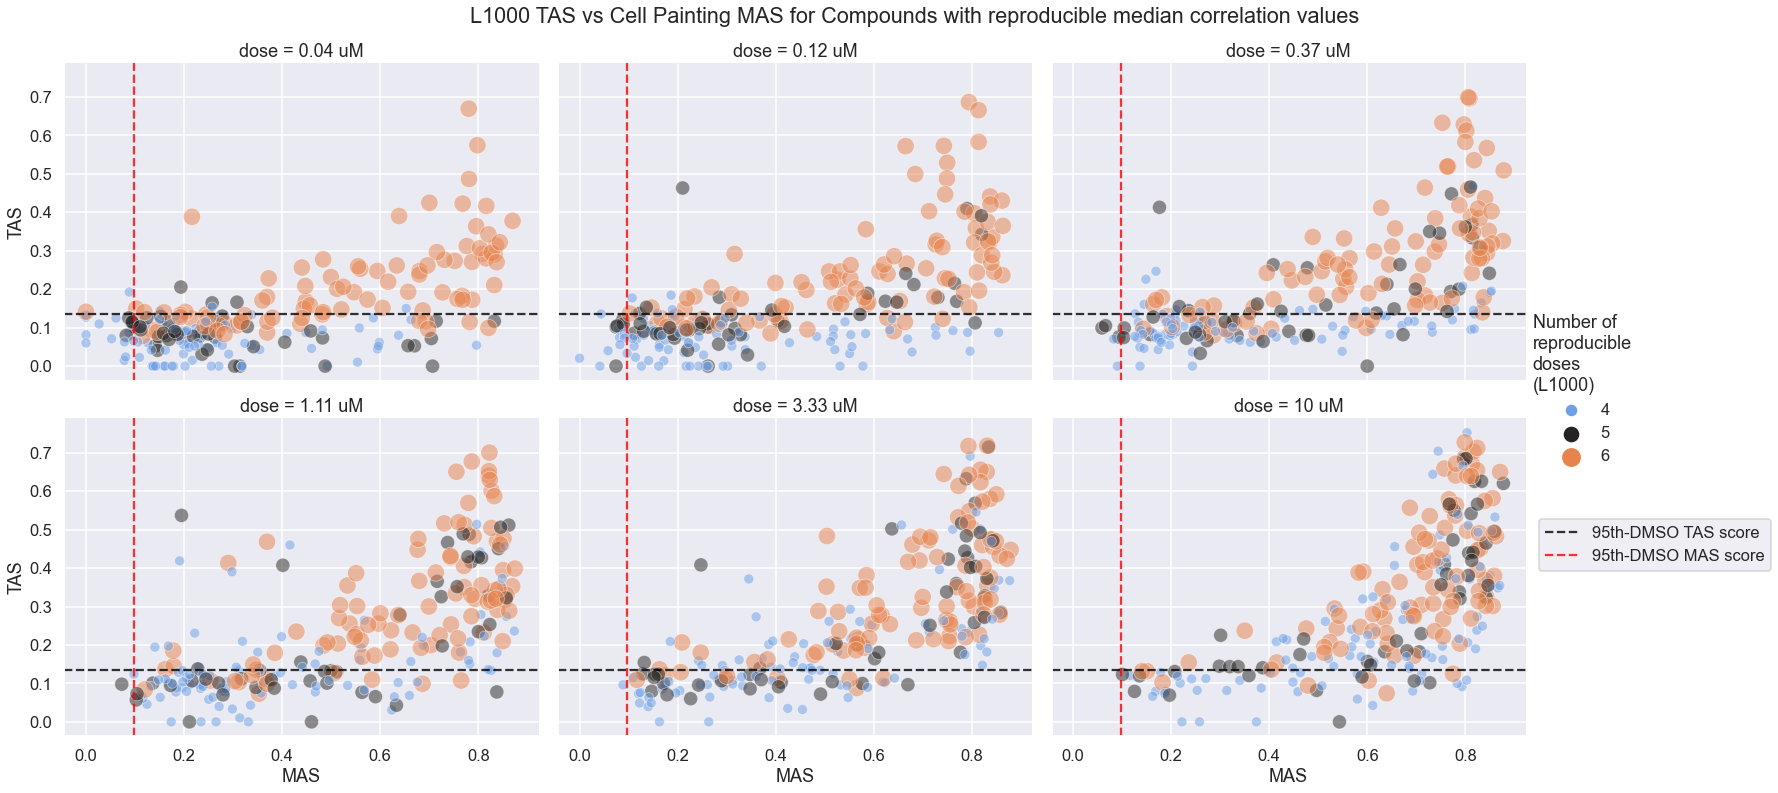

In [58]:
plot_mas_vs_tas(df_stat_all, "L1000 TAS vs Cell Painting MAS for Compounds with reproducible median correlation values",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'stat_TAS_vs_MAS_1b.png',
                hue = 'L1000', alp=0.5, size =(100,300))

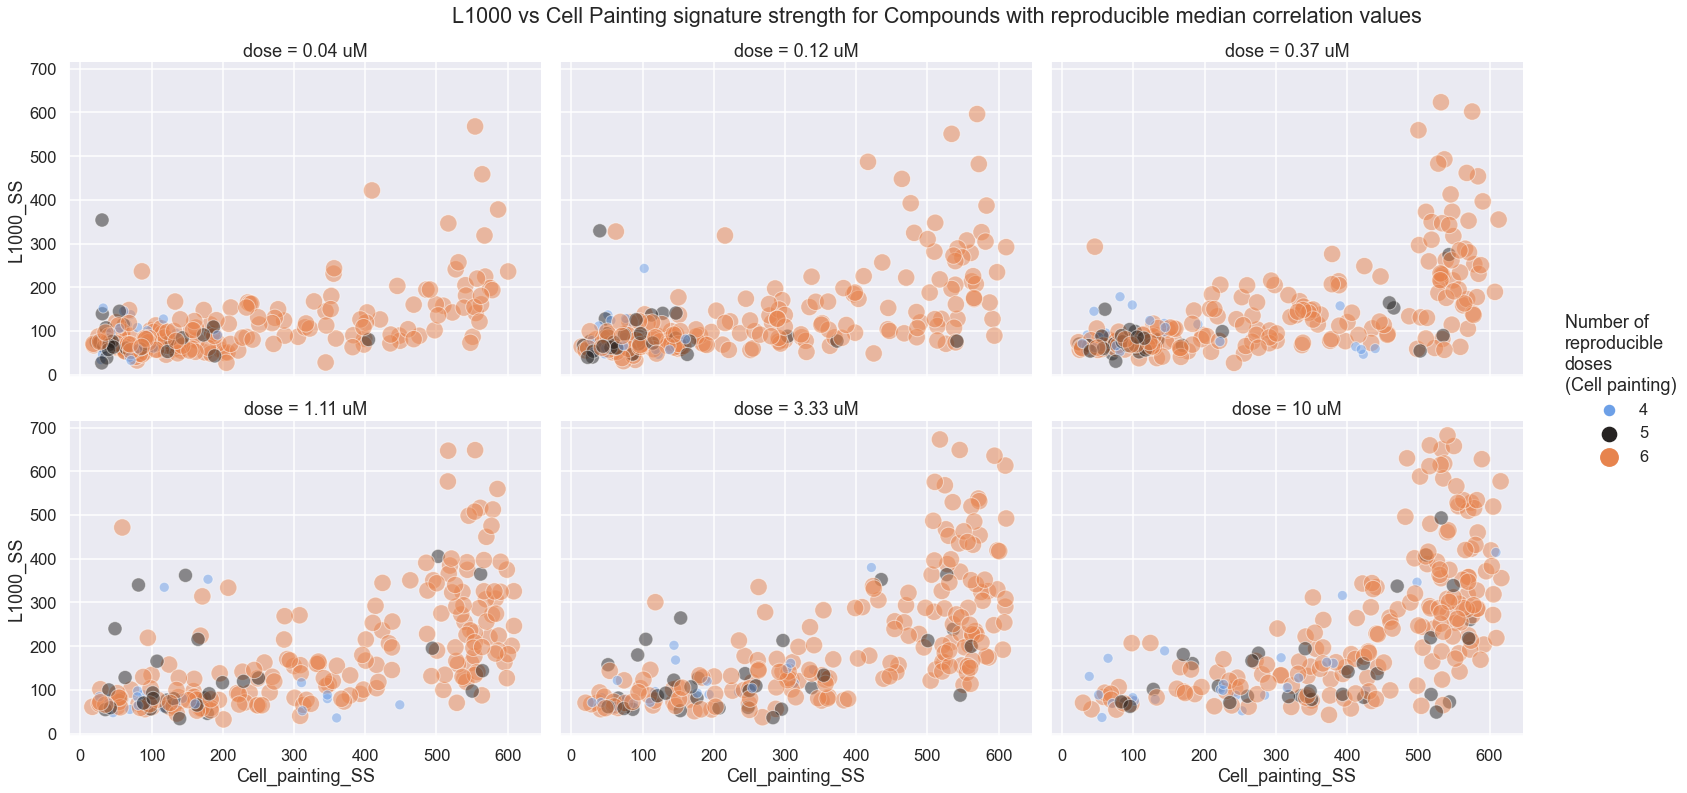

In [59]:
plot_ss(df_stat_all, "L1000 vs Cell Painting signature strength for Compounds with reproducible median correlation values",
                'L1000_cp_figures', 'stat_L1000_SS_vs_CP_SS_1a.png', alp=0.5, size =(100,300))

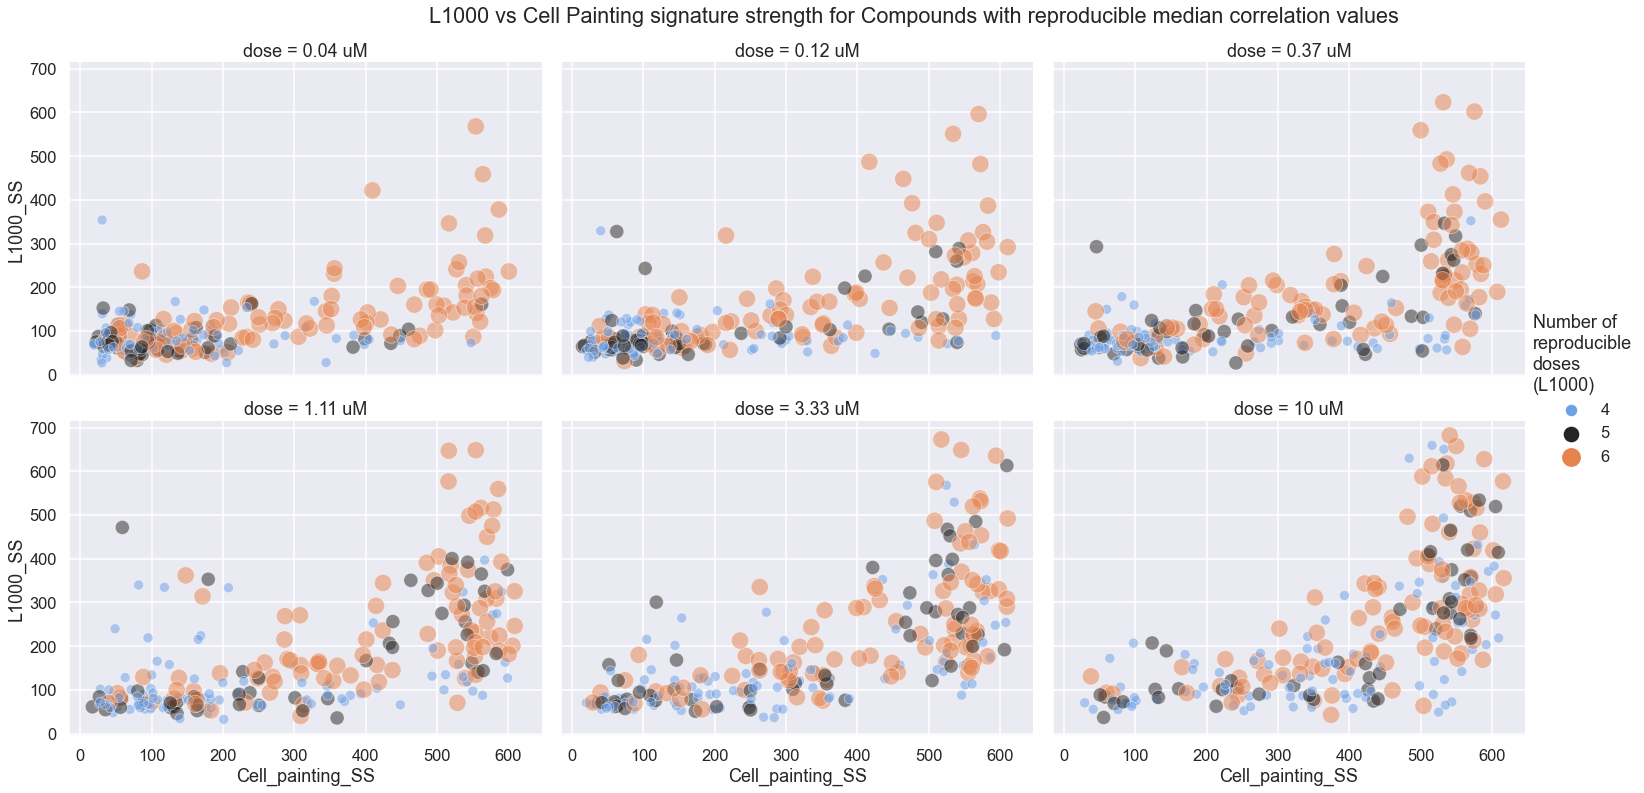

In [60]:
plot_ss(df_stat_all, "L1000 vs Cell Painting signature strength for Compounds with reproducible median correlation values",
        'L1000_cp_figures', 'stat_L1000_SS_vs_CP_SS_1b.png', 
        hue = 'L1000', alp=0.5, size =(100,300))